#**BrandPulse: Decoding SXSW Sentiment for Competitive Intelligence**

##**Business Understanding:**

###**Problem Statement**

Brands invest massive resources in marketing at major events like SXSW, but they lack a real-time, data-driven understanding of public perception. They struggle to answer:
- Is our campaign resonating positively?
- How does sentiment towards our brand compare to our competitors?
- What specific product features or marketing stunts are people talking about (good or bad)?

#### Stakeholders
**1**. **Marketing Directors at Tech Companies** (e.g., Apple, Google):

"Need to measure ROI of SXSW presence."
* “Do we **double down** on this activation or cut our losses?”
* “Which competitor is heating up **right now**?”
* “What messaging is actually **resonating** with the audience?”

**2**. **Brand Strategy Consultants**:

"Need actionable competitive intelligence for client advising."
* “What is our **true position** vs competitors?”
* “What **emerging trends** should we capitalize on?”
* “Where are the **market gaps** we can own?”

**3**. **For a CMO *After SXSW***
* “What was our **actual ROI** on SXSW?”
* “What should we change for next year?”
* “How should we allocate our **next event budget**?”

### Value Proposition
BrandPulse analyzes social media chatter from SXSW to provide quantified brand sentiment and competitive positioning, enabling evidence-based marketing decisions.

In [ ]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.utils import class_weight
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline, Pipeline
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import randint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input

import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('punkt_tab')

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

##**Data Understanding:**

In [ ]:
# Load Dataset
df = pd.read_csv('/content/judge-1377884607_tweet_product_company.csv', encoding='latin1')
df.head()

In [ ]:
# Checking data information
print("Data Information:")
print(df.info())

In [ ]:
print("Dataset Shape:", df.shape)

In [ ]:
# Checking missing values
print("Missing Values:")
df.isnull().sum()

###**Handling the missing values**

In [ ]:
# For 'tweet_text' - Since only 1 value is missing, you can drop that row
# Tweet text is crucial for analysis, so removing it makes sense
df = df.dropna(subset=['tweet_text'])

In [ ]:
# Confirming shape
print("Dataset Shape:", df.shape)

In [ ]:
# For 'emotion_in_tweet_is_directed_at' - This has many missing values(5802), more than half of the total rows (9093)
# Filling with a placeholder
df['emotion_in_tweet_is_directed_at'] = df['emotion_in_tweet_is_directed_at'].fillna('Not Specified')

In [ ]:
# Confirming missing values
# Checking missing values
print("Missing Values:")
df.isnull().sum()

In [ ]:
# Exploring the target variable
print("Sentiment Count:")
senti_count = df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()
senti_count

In [ ]:
# Dropping the 1 count that has no emotion corresponding
df = df[df['is_there_an_emotion_directed_at_a_brand_or_product'].str.strip() != '']

In [ ]:
# Confirming shape
print("Dataset Shape:", df.shape)

In [ ]:
# The new sentiment distribution
print("Sentiment Distribution:")
senti_percent = df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts(normalize = True)
senti_percent

In [ ]:
# Explore brand distribution
print("\nTop Brands Mentioned:")
brand_counts = df['emotion_in_tweet_is_directed_at'].value_counts().head(20)
print(brand_counts)

##**Exploratory Data Analysis**

In [ ]:
# Sentiment Distribution
plt.figure(figsize=(10,8))
sns.countplot(x = "is_there_an_emotion_directed_at_a_brand_or_product", data = df, order = senti_percent.index, palette = 'viridis')
plt.title('Distribution of Emotions Directed at a Brand or Product')
plt.xlabel('Emotion Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Sentiment Distribution (%)
plt.figure(figsize=(6,6))
df["is_there_an_emotion_directed_at_a_brand_or_product"].value_counts().plot.pie(autopct = "%1.1f%%",colors = sns.color_palette("pastel"))
plt.title("Distribution of Emotions Directed at a Brand or Product")
plt.ylabel("");

In [ ]:
# Distribution of tweet length
df['tweet_length'] = df['tweet_text'].astype(str).apply(len)
plt.figure(figsize=(10,8))
sns.histplot(data = df, x = "tweet_length", hue = "is_there_an_emotion_directed_at_a_brand_or_product", palette = 'viridis')
plt.title("Distribution of tweets lengths (Characters)")
plt.xlabel("Tweet Length")
plt.ylabel("Count")
plt.show()

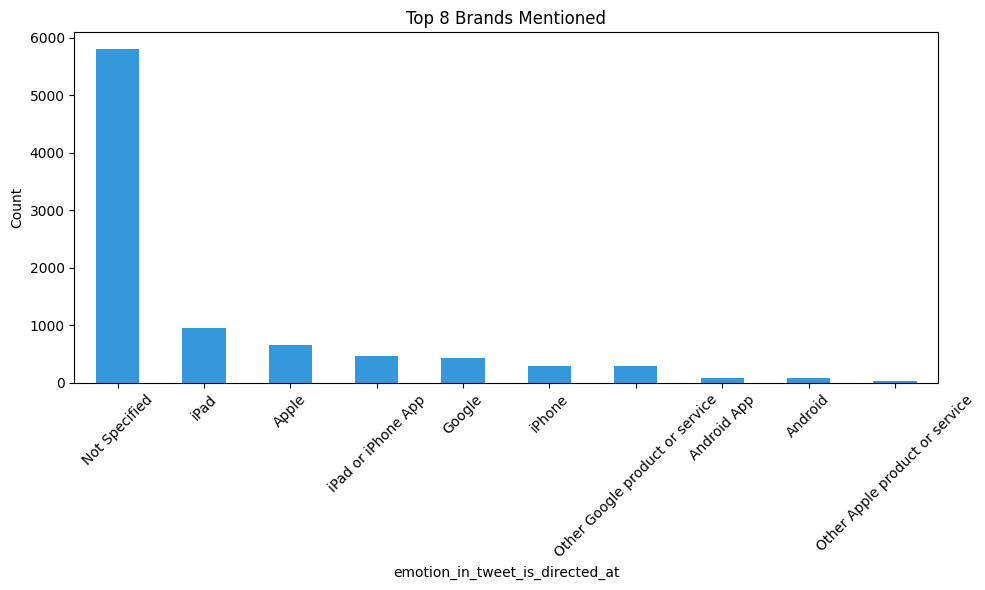

In [18]:
# Brands Distribution
top_brands = df['emotion_in_tweet_is_directed_at'].value_counts()

fig, ax = plt.subplots(figsize=(10, 6))
top_brands.plot(kind='bar', ax=ax, color='#3498db')
ax.set_title('Top 8 Brands Mentioned')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

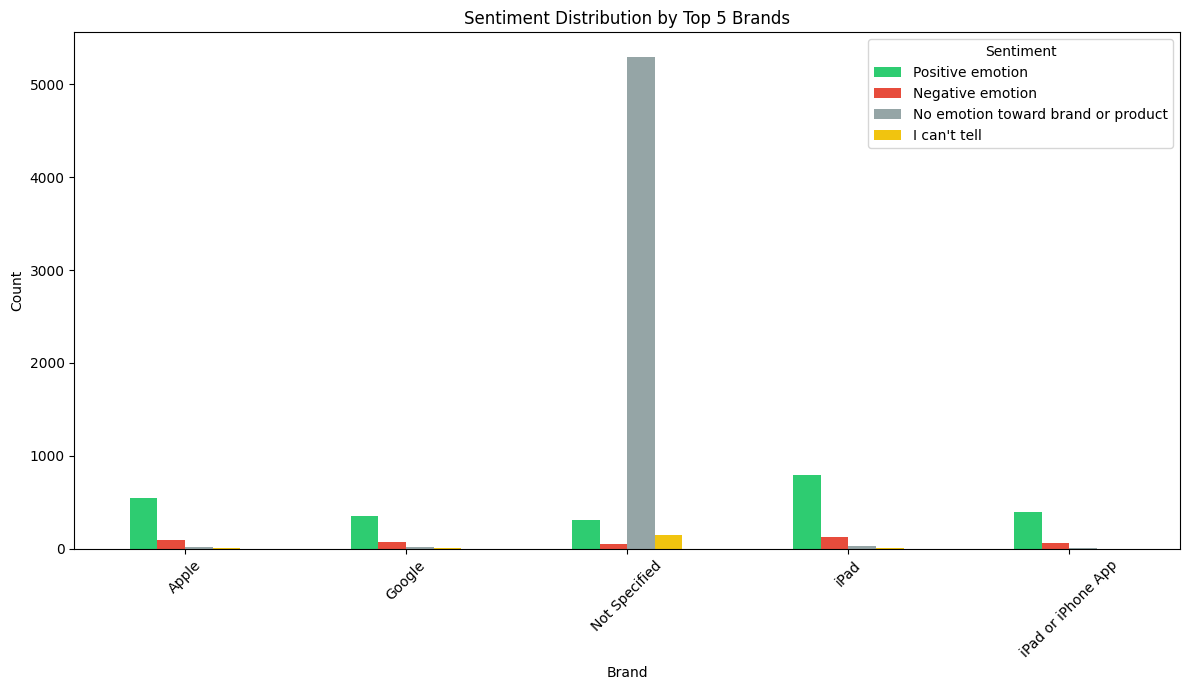

In [19]:
# Sentiment Distribution by top 5 Brands
sentiment_palette = {'Positive emotion': '#2ecc71', 'Negative emotion': '#e74c3c', 'No emotion toward brand or product': '#95a5a6', "I can't tell": '#f1c40f'}

top_5_brands = df['emotion_in_tweet_is_directed_at'].value_counts().head(5).index
brand_sentiment = pd.crosstab(
    df[df['emotion_in_tweet_is_directed_at'].isin(top_5_brands)]['emotion_in_tweet_is_directed_at'],
    df[df['emotion_in_tweet_is_directed_at'].isin(top_5_brands)]['is_there_an_emotion_directed_at_a_brand_or_product']
)

# Ensure all sentiment categories are present and ordered consistently
all_sentiments = ['Positive emotion', 'Negative emotion', 'No emotion toward brand or product', "I can't tell"]
brand_sentiment = brand_sentiment.reindex(columns=all_sentiments, fill_value=0)

fig, ax = plt.subplots(figsize=(12, 7)) # Create a single subplot
brand_sentiment.plot(kind='bar', ax=ax, color=[sentiment_palette[s] for s in all_sentiments])
ax.set_title('Sentiment Distribution by Top 5 Brands')
ax.set_ylabel('Count')
ax.set_xlabel('Brand')
ax.legend(title='Sentiment')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [20]:
# Compare sentiment across different brands
brand_sentiment_pivot = df.pivot_table(
    index='emotion_in_tweet_is_directed_at',
    columns='is_there_an_emotion_directed_at_a_brand_or_product',
    values='tweet_text',
    aggfunc='count',
    fill_value=0
)

# Calculate net sentiment score per brand
brand_sentiment_pivot['net_sentiment'] = (
    brand_sentiment_pivot['Positive emotion'] -
    brand_sentiment_pivot['Negative emotion']
)
brand_sentiment_pivot

is_there_an_emotion_directed_at_a_brand_or_product,I can't tell,Negative emotion,No emotion toward brand or product,Positive emotion,net_sentiment
emotion_in_tweet_is_directed_at,,,,,
Android,0,8,1,69,61
Android App,0,8,1,72,64
Apple,2,95,21,543,448
Google,1,68,15,346,278
Not Specified,147,51,5297,306,255
Other Apple product or service,0,2,1,32,30
Other Google product or service,1,47,9,236,189
iPad,4,125,24,793,668
iPad or iPhone App,0,63,10,397,334


##**Data Preparation**

In [21]:
# Data Cleaning and Preprocessing
def clean_text(text):
    if not isinstance(text, str):
        return "" # Handle non-string inputs gracefully, e.g., for NaN values in the column
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove symbols
    text = re.sub(r'@\w+|#\w+', '', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Initialize stemmer and lemmatizer
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()

    # Apply stemming
    stemmed_tokens = [stemmer.stem(word) for word in tokens]

    # Apply lemmatization to stemmed tokens
    final_tokens = [lemmatizer.lemmatize(word) for word in stemmed_tokens]

    # Join tokens back to text
    cleaned_text = ' '.join(final_tokens)

    return cleaned_text

print("Text cleaning completed!")
print(f"Remaining samples: {len(df)}")

Text cleaning completed!
Remaining samples: 9092


In [22]:
# Apply cleaning to dataset
df['cleaned_text'] = df['tweet_text'].apply(clean_text)

# Remove empty texts after cleaning
df = df[df['cleaned_text'].str.len() > 0]

In [23]:
df[['tweet_text', 'cleaned_text']].head()

,tweet_text,cleaned_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,g iphon hr tweet dead need upgrad plugin station
1,@jessedee Know about @fludapp ? Awesome iPad/i...,know awesom ipad iphon app like appreci design...
2,@swonderlin Can not wait for #iPad 2 also. The...,wait also sale
3,@sxsw I hope this year's festival isn't as cra...,hope year festiv crashi year iphon app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,great stuff fri marissa mayer googl tim reilli...


###**Feature Engineering**

In [24]:
# Prepare target variable - focus on clear sentiments
# Combine 'I can't tell' with 'No emotion' for cleaner classification
df['sentiment'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].replace({'I can\'t tell': 'No emotion toward brand or product'})

# Filter to only include the three main sentiment categories
main_sentiments = ['Positive emotion', 'Negative emotion', 'No emotion toward brand or product']
df = df[df['sentiment'].isin(main_sentiments)]

# Encode target variable
label_encoder = LabelEncoder()
df['emotion'] = label_encoder.fit_transform(df['sentiment'])

print("Target variable prepared!")
print("Sentiment mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
print("\nFinal distribution:")
print(df['sentiment'].value_counts())

Target variable prepared!
Sentiment mapping: {'Negative emotion': np.int64(0), 'No emotion toward brand or product': np.int64(1), 'Positive emotion': np.int64(2)}

Final distribution:
sentiment
No emotion toward brand or product    5542
Positive emotion                      2978
Negative emotion                       570
Name: count, dtype: int64


In [25]:
df.shape

(9090, 7)

In [26]:
# Define brand mapping dictionary
brand_mapping = {
    # Apple group
    'Apple': 'Apple',
    'iPad': 'Apple',
    'iPhone': 'Apple',
    'imac': 'Apple',
    'iPad or iPhone App': 'Apple',
    'Other Apple product or service': 'Apple',

    # Google group
    'Google': 'Google',
    'Android': 'Google',
    'Android App': 'Google',
    'Other Google product or service': 'Google',

    # Others
    'Not Specified': 'Not Specified'
}

# Apply the mapping
df['brand_group'] = df['emotion_in_tweet_is_directed_at'].map(brand_mapping)

# Fill any NaN (for brands not in mapping) with original value
df['brand_group'] = df['brand_group'].fillna(df['emotion_in_tweet_is_directed_at'])
df['brand_group'].value_counts()

,count
brand_group,
Not Specified,5799
Apple,2409
Google,882


##**Data Modelling**
### **Iteration 1: Baseline Model**

In [27]:
# Prepare data for modeling
X = df['cleaned_text']
y = df['emotion']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 7272 samples
Test set: 1818 samples


In [28]:
# TF-IDF Vectorization with n-grams

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
print("Vectorization Complete")

Vectorization Complete


In [29]:
print(X_train_vec)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 67009 stored elements and shape (7272, 5604)>
  Coords	Values
  (0, 3951)	0.29336135725301726
  (0, 2052)	0.1813220120295092
  (0, 369)	0.23015515154593777
  (0, 233)	0.09030024642283316
  (0, 2628)	0.2227359047735773
  (0, 3216)	0.6065671717477166
  (0, 4782)	0.17548308548811756
  (0, 3339)	0.23015515154593777
  (0, 2962)	0.1642434808840025
  (0, 5262)	0.3172681816678751
  (0, 2151)	0.19180690006207768
  (0, 5382)	0.2856650788143354
  (0, 3543)	0.2694545328381594
  (1, 4147)	1.0
  (2, 2304)	0.37983793072633854
  (2, 4761)	0.19337114183623566
  (2, 946)	0.2901623733527961
  (2, 2528)	0.28693229255541686
  (2, 2858)	0.27273001288150184
  (2, 4658)	0.32485361446307315
  (2, 2558)	0.11639433575518587
  (2, 3158)	0.22057178737498534
  (2, 966)	0.41452917183661564
  (2, 3026)	0.3301267904272834
  (2, 3294)	0.25505578644375415
  :	:
  (7268, 3407)	0.5383117406217058
  (7269, 2847)	0.3685322486114142
  (7269, 820)	0.92961496423703


In [30]:
# Logistic Regression as Baseline Model
baseline_model = LogisticRegression(class_weight='balanced', max_iter=1000)
baseline_model.fit(X_train_vec, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [31]:
# Predictions for train data
y_train_baseline_pred = baseline_model.predict(X_train_vec)

# Evaluation
print(f"Accuracy: {accuracy_score(y_train, y_train_baseline_pred):.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train_baseline_pred))
print("\nClassification Report:")
print(classification_report(y_train, y_train_baseline_pred))


Accuracy: 0.79
Confusion Matrix:
[[ 449    5    2]
 [ 294 3457  683]
 [ 108  400 1874]]

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.98      0.69       456
           1       0.90      0.78      0.83      4434
           2       0.73      0.79      0.76      2382

    accuracy                           0.79      7272
   macro avg       0.72      0.85      0.76      7272
weighted avg       0.82      0.79      0.80      7272



In [32]:
# Predictions for test data
y_test_baseline_pred = baseline_model.predict(X_test_vec)

# Evaluation

baseline_f1 = f1_score(y_test, y_test_baseline_pred, average='macro')
baseline_accuracy = accuracy_score(y_test, y_test_baseline_pred)

print(f"Accuracy: {accuracy_score(y_test, y_test_baseline_pred):.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_baseline_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_test_baseline_pred))


Accuracy: 0.65
Confusion Matrix:
[[ 64  31  19]
 [118 745 245]
 [ 41 178 377]]

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.56      0.38       114
           1       0.78      0.67      0.72      1108
           2       0.59      0.63      0.61       596

    accuracy                           0.65      1818
   macro avg       0.55      0.62      0.57      1818
weighted avg       0.69      0.65      0.66      1818



###**Hyperparameter tuning**

In [33]:
tfidf = TfidfVectorizer(
        max_features=5000, # why are we specifying?
        ngram_range=(1, 2),  # Include unigrams and bigrams
        stop_words='english',
        min_df=2,
        max_df=0.95

)
# Transform text data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"TF-IDF Features: {X_train_tfidf.shape[1]}")

TF-IDF Features: 5000


###**Iteration 2: Random Forest Model**

In [34]:
rf_model = RandomForestClassifier(
    n_estimators=100,          # number of trees
    max_depth=None,            # allow full tree growth
    class_weight='balanced',   # paying attention to the imbalance
    random_state=42,
    n_jobs=-1                  # use all CPU cores
)
rf_model.fit(X_train_tfidf, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [35]:
# Predictions
y_pred_rf = rf_model.predict(X_test_tfidf)

# Evaluation
rf_f1 = f1_score(y_test, y_pred_rf, average='macro')
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print("Random Forest with TF-IDF")
print(f"Macro F1-Score: {rf_f1:.4f}")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Improvement over baseline: {rf_f1 - baseline_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

Random Forest with TF-IDF
Macro F1-Score: 0.5316
Accuracy: 0.6771
Improvement over baseline: -0.0390

Classification Report:
                                    precision    recall  f1-score   support

                  Negative emotion       0.60      0.22      0.32       114
No emotion toward brand or product       0.70      0.86      0.77      1108
                  Positive emotion       0.62      0.42      0.51       596

                          accuracy                           0.68      1818
                         macro avg       0.64      0.50      0.53      1818
                      weighted avg       0.67      0.68      0.65      1818



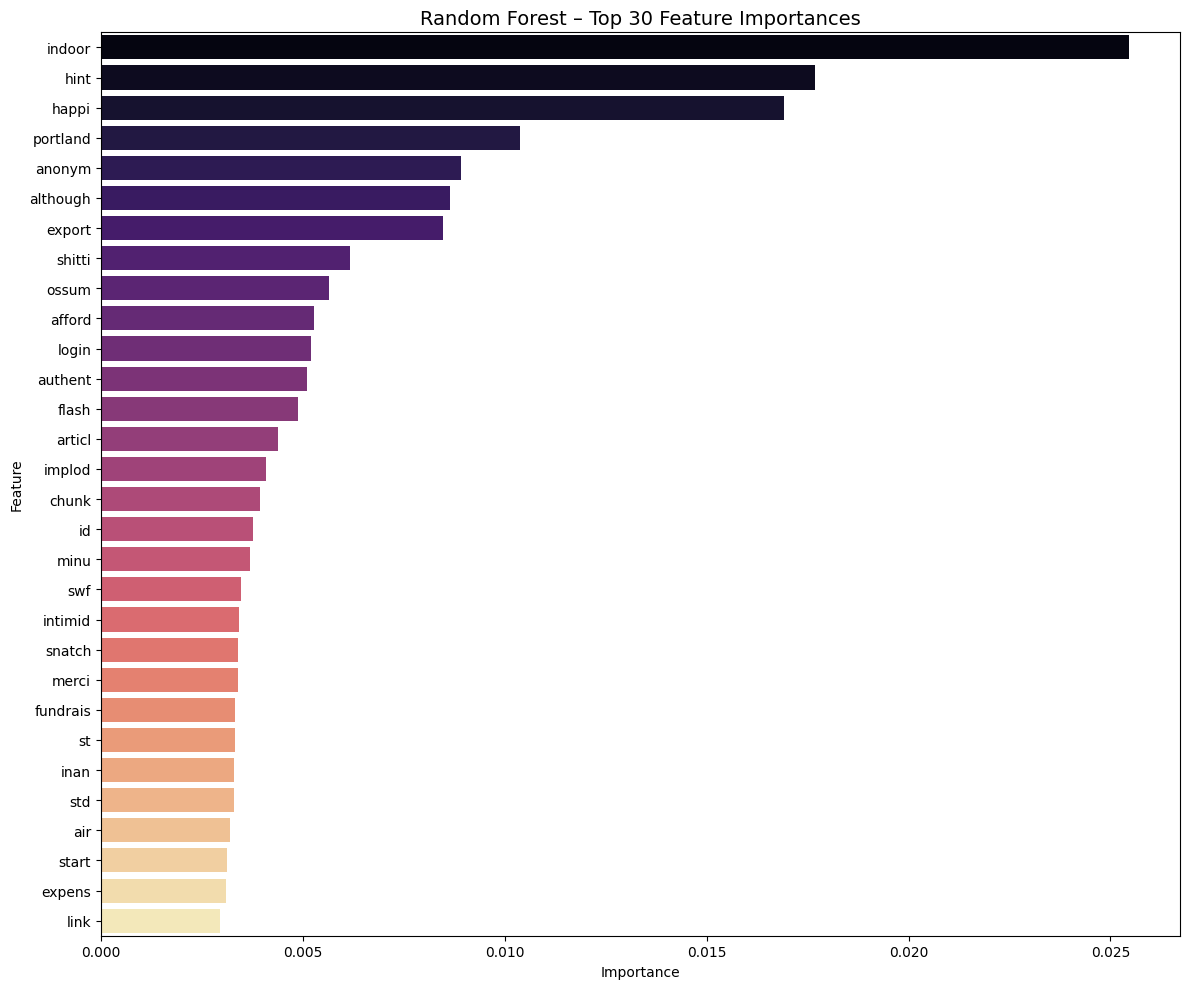

Top 10 Random Forest features:
 1. indoor               0.02545
 2. hint                 0.01768
 3. happi                0.01691
 4. portland             0.01038
 5. anonym               0.00892
 6. although             0.00866
 7. export               0.00847
 8. shitti               0.00617
 9. ossum                0.00565
10. afford               0.00529


In [47]:
# RANDOM FOREST – TOP 30 FEATURE IMPORTANCES

# 1) Get feature importances and sort indices descending
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# 2) Get feature names from the TF-IDF vectorizer you actually use
feature_names = vectorizer.get_feature_names_out()

# 3) Select top 30 features
top_n = 30
top_idx = indices[:top_n]
top_features = feature_names[top_idx]
top_importances = importances[top_idx]

# 4) Plot top 30
plt.figure(figsize=(12, 10))
sns.barplot(x=top_importances, y=top_features, palette="magma")
plt.title("Random Forest – Top 30 Feature Importances", fontsize=14)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# 5) Print top 10 for inspection
print("Top 10 Random Forest features:")
for i, (feat, imp) in enumerate(zip(top_features[:10], top_importances[:10]), start=1):
    print(f"{i:2d}. {feat:<20} {imp:.5f}")


### **Iteration 3: Neural Network Approach**

In [ ]:
# Encode labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # 0,1,2 for classes

Tokenization & Sequences

In [ ]:
max_words = 10000  # Only keep top 10k most common words
max_len = 50       # max tweet length (pad shorter - add zeros, truncate longer - cut extra words)

# Fitting tokenizer on training dataset
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>") # Use of max_worda, everything else consider OutOfVocabulary
tokenizer.fit_on_texts(X_train) # Learns texts and builds dictionary

In [ ]:
# Converting texts to numbers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to same length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post') # Post means add zeros after the tweet
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

In [ ]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
embedding_dim = 100 # Each word to be represented by a 100-dimensional vector

model = Sequential([
    Input(shape=(max_len,)),
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len), # Converts each word index into a meaningful vector
    Bidirectional(LSTM(64, return_sequences=False)), # Reads the sentence in both directions, helps with context. Return_sequences=False
                                                     # means only the final output is kept
    Dropout(0.5), # Randomly turns 50% of neurons OFF during training, preventing overfitting, enabling learn of robust patterns
    Dense(64, activation='relu'), # Combines everything learnt, learns deeper non-linear features, 64 is a good middle size (not so small/large)
    Dropout(0.3), # reduces overfitting, but with 30% dropout
    Dense(len(np.unique(y_train)), activation='softmax')  # multi-class
])

model.compile(
    loss='sparse_categorical_crossentropy', # labels 0,1,2 (not one-hot encoded), Multi-class classification
    optimizer=Adam(learning_rate=0.001), # Smart gradient descent algorithm, Good default choice for NLP.
    metrics=['accuracy']
)

model.summary()

In [ ]:
# Train Neural Network
early_stop = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)
history = model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[early_stop],
    verbose=2
)

In [ ]:
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_classes))
print("\nClassification Report:\n", classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

##**Model Comparison and Final Evaluation**

In [48]:
# BASELINE metrics (e.g., Logistic Regression or Naive Bayes, depending on your notebook)
baseline_acc = accuracy_score(y_test, y_test_baseline_pred)
baseline_f1 = f1_score(y_test, y_test_baseline_pred, average="macro")

# RANDOM FOREST metrics
rf_acc = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf, average="macro")

# Build comparison table
results = [
    ["Baseline model", baseline_acc, baseline_f1],
    ["Random Forest", rf_acc, rf_f1],
]

comparison_df = pd.DataFrame(results, columns=["Model", "Test Accuracy", "Macro F1"])

print("Model performance comparison:\n")
display(
    comparison_df.style.highlight_max(
        subset=["Test Accuracy", "Macro F1"], color="lightgreen"
    )
)

# Identify best model by Macro F1
best_idx = comparison_df["Macro F1"].idxmax()
best_row = comparison_df.iloc[best_idx]

print("\nBest model by Macro F1:")
print(f"  Model:       {best_row['Model']}")
print(f"  Test Acc.:   {best_row['Test Accuracy']:.3f}")
print(f"  Macro F1:    {best_row['Macro F1']:.3f}")

Model performance comparison:



,Model,Test Accuracy,Macro F1
0,Baseline model,0.652365,0.570654
1,Random Forest,0.677118,0.531622



Best model by Macro F1:
  Model:       Baseline model
  Test Acc.:   0.652
  Macro F1:    0.571


In [50]:
import joblib

# Build pipeline: TF-IDF vectorizer + baseline classifier
pipeline = Pipeline([
    ("tfidf", vectorizer),
    ("classifier", baseline_model),
])

# Fit on all available data X, y (text and labels)
pipeline.fit(X, y)

# Quick test on a few example tweets
example_tweets = [
    "Love my new iPad, best purchase ever!",
    "Google app keeps crashing, really annoying.",
    "SXSW has iPhone demos this week.",
    "Battery life on this iPad is disappointing.",
    "Apple keynote was amazing as always!"
]

example_preds = pipeline.predict(example_tweets)

print("Pipeline test predictions:\n")
for txt, pred in zip(example_tweets, example_preds):
    label = label_encoder.inverse_transform([pred])[0]
    print(f"'{txt[:60]}...' → {label}")

# Save pipeline and label encoder
joblib.dump(pipeline, "brandpulse_pipeline.pkl")
joblib.dump(label_encoder, "brandpulse_label_encoder.pkl")
print("\nSaved: brandpulse_pipeline.pkl, brandpulse_label_encoder.pkl")

Pipeline test predictions:

'Love my new iPad, best purchase ever!...' → Positive emotion
'Google app keeps crashing, really annoying....' → Positive emotion
'SXSW has iPhone demos this week....' → No emotion toward brand or product
'Battery life on this iPad is disappointing....' → Positive emotion
'Apple keynote was amazing as always!...' → No emotion toward brand or product

Saved: brandpulse_pipeline.pkl, brandpulse_label_encoder.pkl
